In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = None
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import datetime as dt
import datetime

In [2]:
# load the cleaned superstore dataset
superstore = pd.read_excel('dataset/superstore_cleaned.xlsx')

# Customer Segmentation

The most widely used model for customer segmentation is RFM segmentation model. What is RFM segmentation? RFM segmentation is behavioral customer segmentation model based on three metrics: `Recency` (R), `Frequency` (F), and `Monetary` (M).
- `Recency`: days since last customer transaction.
- `Frequency`: number of transactions in specific interval of 2 different timestamps.
- `Monetary`: total spend in the specific interval of 2 different timestamps.

A new metric, `Length`, is also added which defines how long a person has been becoming a customer in Superstore.

In sum, we modify the RFM model to be **LRFM model**.
- `Length`: length of time since the first transaction of customer to a specific $T_n$ timestamp. [unit: months]
- `Recency`: length of time (e.g. days) since last customer transaction to a specific $T_n$ timestamp. [unit: days]
- `Frequency`: number of total transactions in a specific interval of 2 different timestamps, $T_1$ to $T_n$.  [unit: total]
- `Monetary`: total money spend in a specific interval of 2 different timestamps, $T_1$ to $T_n$. [unit: USD]

3 clustering algorithms is used for LRFM model segmentation, that is K-Means, Gaussian Mixture Model, and Hierarchical Clustering and then these 3 algorithms will be compared.

## Prepare the data for segmentation

Transform the user per transaction-based data into user-based data.

In [3]:
# create the hypothetical date of today
snapshot_date = superstore['Order Date'].max() + dt.timedelta(days = 1)
print('The last transaction datetime in Superstore:', superstore['Order Date'].max())
print('The hypothetical datetime of today:', snapshot_date)

The last transaction datetime in Superstore: 2021-12-30 00:00:00
The hypothetical datetime of today: 2021-12-31 00:00:00


In [4]:
# create LRFMC table
customers = superstore.groupby(['Customer ID', 'Customer Name']).agg(Length = ('Order Date', lambda x: (snapshot_date.year - x.min().year)*12 + \
                                                                                                   (snapshot_date.month - x.min().month)), 
#                                                                  Length = ('Order Date', lambda x: (snapshot_date - x.min()).days),
                                                                 Recency = ('Order Date', lambda x: (snapshot_date - x.max()).days),
#                                                                  Recency =  ('Order Date', lambda x: (snapshot_date.year - x.max().year)*12 + \
#                                                                                                    (snapshot_date.month - x.max().month)),
                                                                 Frequency = ('Order ID', 'count'),
                                                                 Monetary = ('Sales', 'sum'))
customers

,,Length,Recency,Frequency,Monetary
Customer ID,Customer Name,,,,
AA-10315,Alex Avila,45,185,11,5563.560
AA-10375,Allen Armold,44,20,15,1056.390
AA-10480,Andrew Allen,43,260,12,1790.512
AA-10645,Anna Andreadi,42,56,18,5086.935
AB-10015,Aaron Bergman,46,416,6,886.156
...,...,...,...,...,...
XP-21865,Xylona Preis,47,44,28,2374.658
YC-21895,Yoseph Carroll,37,5,8,5454.350
YS-21880,Yana Sorensen,35,10,12,6720.444


In [5]:
# helper function to check the distribution
def check_distribution(df):
    plt.figure(figsize = (20, 20))
    i = 1
    for col in df.columns:
        plt.subplot(5, 5, i)
        ax = sns.distplot(x = df[col], color ='#676FA3')
        plt.title('"{}" distribution'.format(col), loc = 'center', fontsize = 15)
        plt.xticks(rotation = 20, fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.tight_layout()
        i += 1
    plt.show()

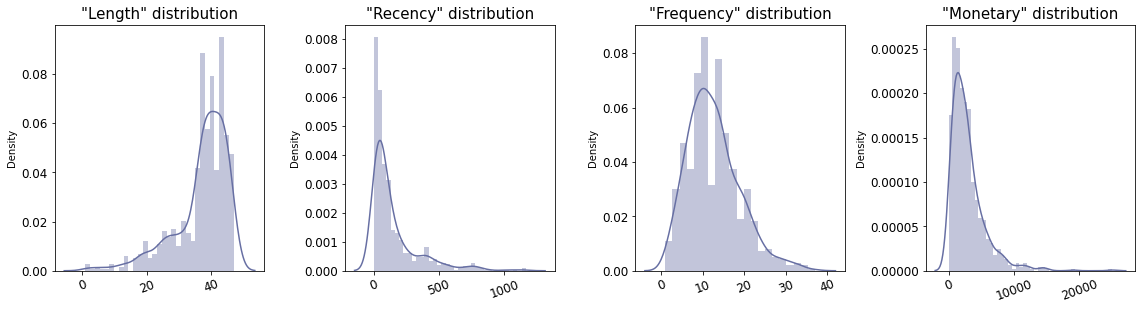

In [6]:
check_distribution(customers)

- The distributions are slightly skewed for `Frequency` while the others are very skewed.

## Segmentation using K-Means

K-Means algorithm is the most commonly and widely used for clustering algorithm. But this algorithm assumes and works well when the data points on N-dimensional features space are circularly (or spherically) clustered with similar density and size between each cluster [(soure)](https://www.r-bloggers.com/2017/08/exploring-assumptions-of-k-means-clustering-using-r/#:~:text=K%2DMeans%20clustering%20method%20considers,the%20data%20and%20forms%20clusters.). It is also fast and efficient in terms of computational cost.

### Data preprocessing

K-Means algorithm works well when the features of the data are at uniform variance (zero mean and one standard deviation). This is because K-Means algorithm works with distance-based algorithm. So we have to scale the data first. Scaling the data also helps the algorithm to converge faster.

These below are the helper functions to execute and analyze K-Means clustering easier, at least for me.

In [7]:
# transform the data into normal distribution
from sklearn.preprocessing import power_transform
def normal_transformation(df):
    temp_df = df.copy()
    
    temp_df = power_transform(temp_df, method = 'yeo-johnson', standardize = False)
    temp_df = pd.DataFrame(temp_df, index = df.index, columns = df.columns)
    return temp_df

# scale the data
from sklearn.preprocessing import MinMaxScaler, StandardScaler
def scaling(df, scaler):
    temp_df = df.copy()
    
    scl = scaler
    temp_df = scl.fit_transform(temp_df)
    temp_df = pd.DataFrame(temp_df, index = df.index, columns = df.columns)
    return temp_df

In [8]:
# helper function for Elbow method and Silhouette method
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline

def find_optimal_K_kmeans(df, K):
    model = KMeans(random_state = 42)
    
    # plot the optimal number of clusters (Elbow and Silhouette)
    metrics = ['distortion', 'silhouette']
    K_opt = []
    for i in range(2):
        vis = KElbowVisualizer(model, k = K, metric = metrics[i], timings = False, locate_elbow = True)
        vis.fit(df)
        vis.show()
        K_opt.append(vis.elbow_value_)
        
    # plot Silhouette analysis
    X = df
    K_opt = np.sort(K_opt)
    for n_clusters in range(K_opt[0], K_opt[1] + 1, 1):
        fig, ax1 = plt.subplots(figsize = (6, 4))
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # KMeans
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)
        sample_silhouette_values = silhouette_samples(X, cluster_labels)
        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
        ax1.set_title("The silhouette plot of n_clusters = {} with silhouette_avg = {}".format(n_clusters, silhouette_avg))
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

In [9]:
# helper function for modelling using K-Means

# modelling K-Means
def kmeans_clustering(k, df, label_name, plot_show):
    temp_df = df.copy()
    
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(temp_df)
    temp_df[label_name] = kmeans.labels_ + 1
    
    # plot the K-Means result
    _ = dimen_reduction(temp_df.iloc[:, :-1], 
                        PC = 3, plot_PC = plot_show, labels = kmeans.labels_ + 1)
    return temp_df[label_name], _

# reduce the dimensions to plot the K-Means results
from sklearn.decomposition import PCA
import plotly.express as px
def dimen_reduction(df, PC, plot_PC, labels):
    temp_df = df.copy()
    
    pca = PCA(n_components = PC)
    temp_df = pca.fit_transform(temp_df)
    temp_df = pd.DataFrame(temp_df, index = df.index, columns = ['PC{}'.format(i+1) for i in range(PC)])
    
    # show explained_variance_ratio_
    fig, ax = plt.subplots(figsize = (10, 4), nrows = 1, ncols = 2)
    print('Total Variance Explained:', sum(pca.explained_variance_ratio_))
    pd.DataFrame(pca.explained_variance_ratio_).plot(kind = 'bar', alpha = 0.6, ax = ax[0], legend = None)
    _ = 0
    total_explained_variance_ratio_ = []
    for i in pca.explained_variance_ratio_:
        _ += i
        total_explained_variance_ratio_.append(_)
    pd.DataFrame(total_explained_variance_ratio_).plot(kind = 'line', marker = 'o', ax = ax[0], legend = None)
    ax[0].set_xlabel('Principle Components')
    ax[0].set_ylabel('Percentage Variance Explained')
    ax[0].set_title('Scree Plot')
    
    # show reduced dimension plot
    if plot_PC == True:
        if PC >= 2:
            temp_df.plot(kind = 'scatter', x = 'PC1', y = 'PC2', c = labels, colormap = 'viridis', colorbar = False, ax = ax[1])
            ax[1].set_xlabel('PC1')
            ax[1].set_ylabel('PC2')
            ax[1].set_title('PC1 and PC2 Plot')
            plt.tight_layout()
            plt.show()
            
        if PC >= 3:
            import plotly.express as px
            fig = px.scatter_3d(temp_df, x = 'PC1', y = 'PC2', z = 'PC3', color = labels)
            fig.update_layout(title_text = 'PC1, PC2, and PC3 plot')
            fig.show('png')
    return temp_df

In [10]:
# helper function for interpreting the clustering results

# radar plot
import plotly.graph_objects as go
def radar_plot(df, label_name, fill_in = None, name = '<blank>'):
    
    # prepare the data to be plotted
    df = df.groupby([label_name]).agg('mean').transform(lambda x: x/x.max()).T
    df = pd.concat([df, pd.DataFrame(df.loc[df.index[0],:]).T], axis = 0)
    
    # plot using radar plot
    fig = go.Figure()
    for cluster in df.columns:
        fig.add_trace(go.Scatterpolar(
            r = df[cluster],       
            theta = df.index,
            fill = fill_in,
            name = 'cluster {}'.format(cluster)))
    fig.update_layout(title_text = 'Radar Plot using {}'.format(name))  
    fig.show('png')
    
# relative impotance and mean agg heatmap plot
import seaborn as sns
def heatmap_plot(df, label_name):
    fig, ax = plt.subplots(figsize = (10, 4), ncols = 2, nrows = 1)
    # relative important plot
    cluster_avg = df.groupby([label_name]).mean() 
    population_avg = df.iloc[:, :-1].mean()
    relative_imp = (cluster_avg / population_avg) - 1
    min_ = abs(relative_imp.min().min())
    max_ = relative_imp.max().max()
    sns.heatmap(data = relative_imp.T, annot = True, fmt = '.2f', 
                cmap = 'seismic', linewidths = 0.1, vmin = -max([min_, max_]), vmax = max([min_, max_]), ax = ax[0])
    ax[0].set_title('Relative importance of features')
    
    # aggregation with mean (normalized) plot
    agg_mean = df.groupby([label_name]).agg('mean').transform(lambda x: x/x.max()).T
    sns.heatmap(agg_mean, cmap = 'Reds', annot = True, 
                fmt = '.2f', linewidths = 0.1, ax = ax[1])
    ax[1].set_title('Mean Agg of features (normalized)')
    plt.tight_layout()
    plt.show()

### LRFM model

We will use the `Length`, `Recency`, `Frequency`, and `Monetary` to segment the customer behaviour.

In [11]:
# take the LRFM data
data = scaling(customers.iloc[:, :4], StandardScaler())
data.head()

,,Length,Recency,Frequency,Monetary
Customer ID,Customer Name,,,,
AA-10315,Alex Avila,0.935607,0.199889,-0.256912,1.015112
AA-10375,Allen Armold,0.816075,-0.686762,0.384256,-0.700590
AA-10480,Andrew Allen,0.696543,0.602912,-0.096620,-0.421139
AA-10645,Anna Andreadi,0.577010,-0.493311,0.865131,0.833680
AB-10015,Aaron Bergman,1.055139,1.441199,-1.058371,-0.765391


#### Find the optimal number of clusters

Before clustering with K-Means, We need to define the number of clusters to use. In order to find the optimal number of clusters, we will use Elbow method and Silhouette method. Specifying the number of clusters is one of the drawbacks of using K-Means clustering.

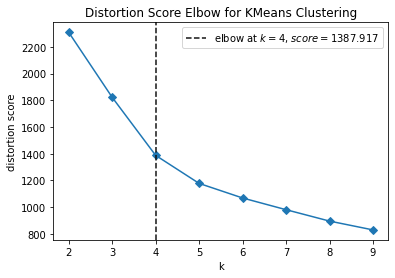

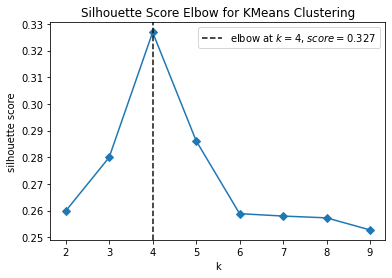

For n_clusters = 4 The average silhouette_score is : 0.32690038588371867


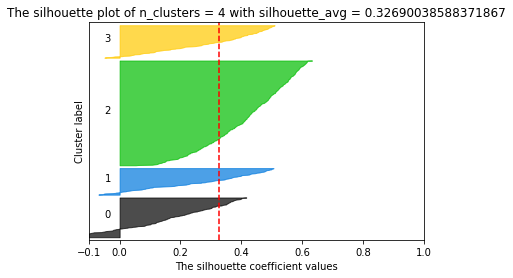

In [12]:
# find the optimal number of clusters
find_optimal_K_kmeans(df = data, 
                      K = (2, 10))

Insights:
- The optimal number of clusters are 4.

#### Modelling

We will perform K-Means clustering with K = 4.

======================================================= 4 clusters =======================================================
Total Variance Explained: 0.8960122097694596


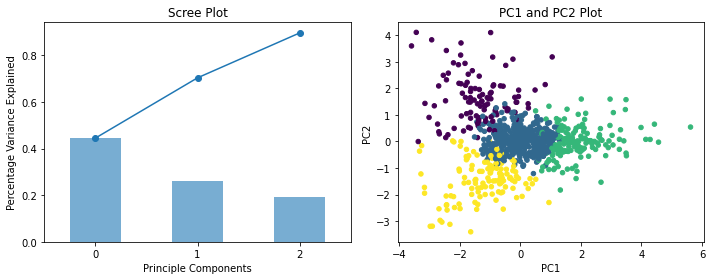

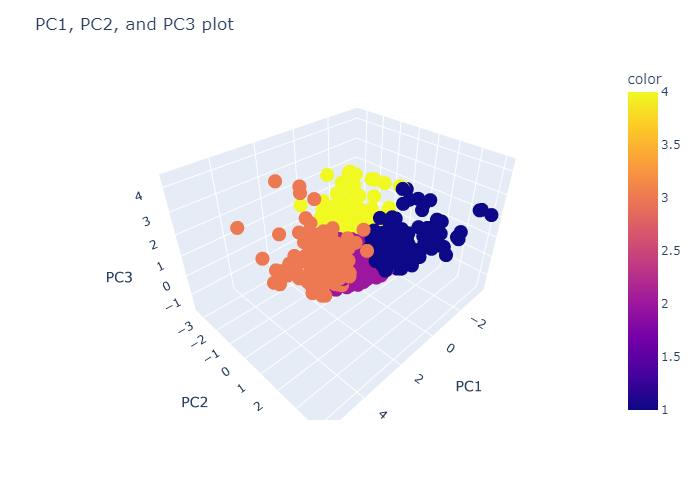

In [13]:
# get the clustering labels using K-Means clustering
labels = dict()
clusters = [4]       # define number of clusters to be analyzed -> 4 clusters
for cluster in clusters:
    print('='*55, '{} clusters'.format(cluster), '='*55)
    cluster_labels, _ = kmeans_clustering(k = cluster, 
                                          df = data, 
                                          label_name = 'Customer Labels',
                                          plot_show = True)
    labels['{} clusters'.format(cluster)] = cluster_labels.values

Insights:
- From the PCA plots, we get 89.6% explained variance ratio. So we lost the information in the dataset about 10% when plotting the data points in 3 dimension. This is not too bad to perform 3D plot with 3 Principal Components of PCA.
- We can see the LRFM model is not clustered far away from each other and not sperically clustered.

#### Interpretation of clusters

We will interpret our results by using `groupby()` method for each group of clusters to see how is the mean for each cluster and using relative importance of cluster features compared to population (the customers dataframe).

======================================================= 4 clusters ==================================================


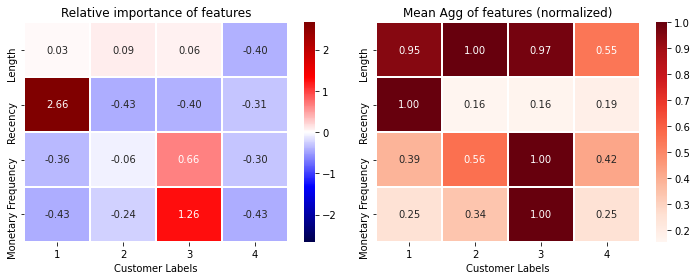

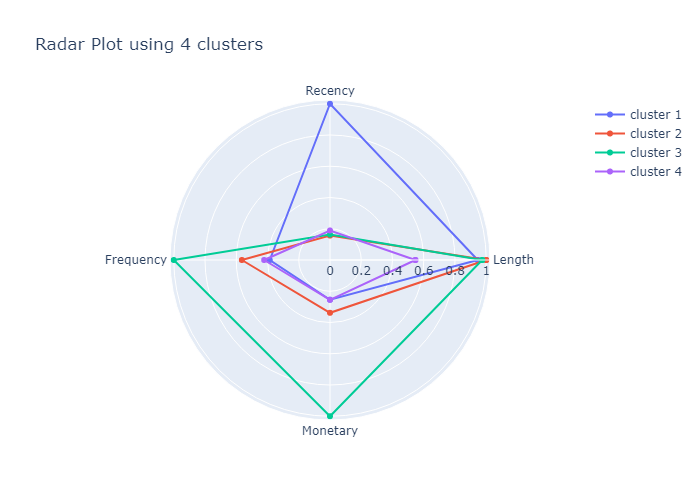

In [14]:
# Interpret the clusters
clustered_customers = customers[data.columns].copy()
for key, val in labels.items():
    print('='*55, '{}'.format(key), '='*50)
    clustered_customers['Customer Labels'] = val
    heatmap_plot(clustered_customers, label_name = 'Customer Labels')
    radar_plot(clustered_customers, label_name = 'Customer Labels', name = key)

Insights:
- We see that with 4 clusters, the characteristic (LRFM metric) of each cluster is different from each other.

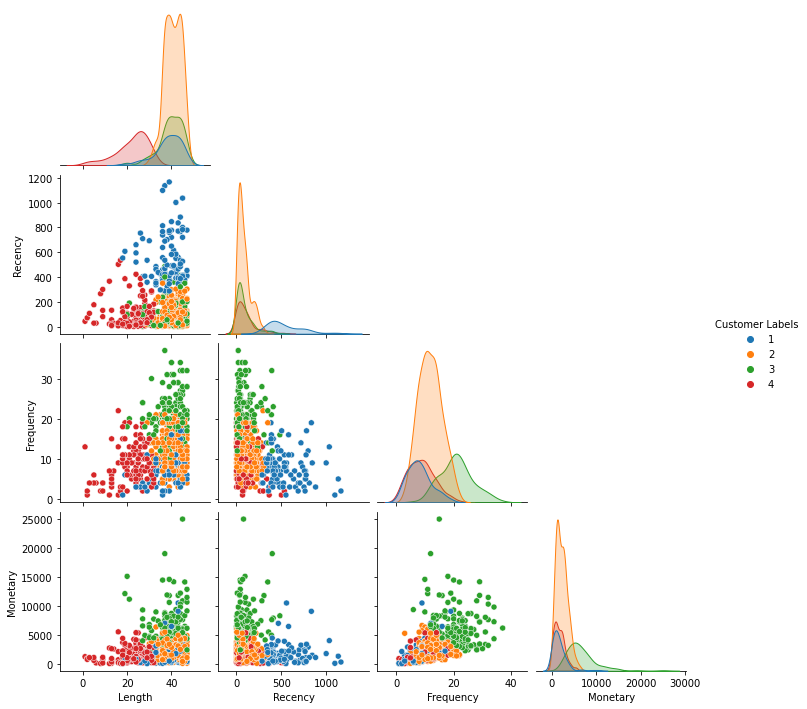

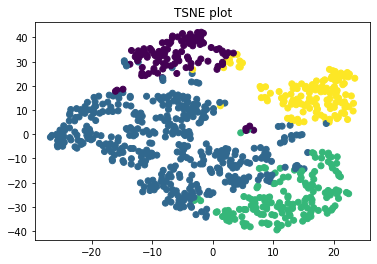

In [15]:
clustered_customers['Customer Labels'] = labels['4 clusters']
sns.pairplot(clustered_customers, hue = 'Customer Labels', palette = 'tab10', corner = True)
plt.show()

from sklearn.manifold import TSNE
tsne = TSNE(learning_rate = 'auto')
transformed = tsne.fit_transform(data.values)

plt.scatter(transformed[:,0], transformed[:,1],
             c = labels['4 clusters'])
plt.title('TSNE plot')
plt.show()

#### Assign the best K clusters and name each cluster

In [16]:
# assign K = 4 as the number of clusters
final_customers_kmeans = customers.iloc[:, :4].copy()
final_customers_kmeans['Customer Labels'] = labels['4 clusters']
final_customers_kmeans.head()

,,Length,Recency,Frequency,Monetary,Customer Labels
Customer ID,Customer Name,,,,,
AA-10315,Alex Avila,45,185,11,5563.560,2
AA-10375,Allen Armold,44,20,15,1056.390,2
AA-10480,Andrew Allen,43,260,12,1790.512,2
AA-10645,Anna Andreadi,42,56,18,5086.935,3
AB-10015,Aaron Bergman,46,416,6,886.156,1


### Interpret LRFM Model (K-Means)

Insights:
- `final_customers_kmeans`:
    - `Cluster 1`: This can be interpreted as `"Lost"` customer segment. They are relatively old customers (L = 2) but their last purchased are very long ago (R = 1) with the lowest number of purchases (F = 1) and the lowest total spent (M = 1) compare to other clusters. It looks like this cluster contains a few high spender customers with low frequency of purchasing product (It may be expensive product).
    - `Cluster 2`: This can be interpreted as `"Important"` customer segment. They are  the oldest customers (L = 4) and they purchase very recently (R = 4) but not the most frequently (F = 3) and spent quite a lot (M = 3).
    - `Cluster 3`: This can be interpreted as `"Champion"` customer segment. They are old customers (L = 3) who have purchased quite recently (R = 3) and the most frequent buyer (F = 4) and spent the most (M = 4).
    - `Cluster 4`: This can be interpreted as `"Potential"` customer segment. They are new customers (L = 1) but their last purchased are quite a long (R = 2) with good amount of purchases (F = 2) and money spent (M = 2).

In [17]:
# final_customers_kmeans

# name each segment of customers
final_customers_kmeans['Customer Segment'] = final_customers_kmeans['Customer Labels']\
                                                    .apply(lambda x: 'Lost' if x == 1 else(
                                                                     'Important' if x == 2 else(
                                                                     'Champion' if x == 3 else(
                                                                     'Potential'))))
final_customers_kmeans.groupby('Customer Segment').agg({'Length':'mean',
                                                        'Recency':'mean',
                                                        'Frequency':'mean',
                                                        'Monetary':['mean', 'count']}).round(2)

Length Recency Frequency Monetary      
                   mean    mean      mean     mean count
Customer Segment                                        
Champion          39.57   88.11     20.90  6538.97   155
Important         40.62   84.44     11.79  2209.57   407
Lost              38.40  540.52      8.06  1661.99   104
Potential         22.20  102.11      8.81  1665.50   127

## Segmentation using Gaussian Mixture Models

Gaussian Mixture Models is more advanced algorithm for clustering. This model is a probabilistic model based on gaussian distribution function. If we have data points on N-dimensional features space then we would have a mixture of `K` Gaussian distributions (where `K` is equivalent to the number of clusters), each having a certain mean vector and covariance matrix.

Basically K-Means algorithm only updates the mean of the centroids in N-features space while Gaussian Mixture Models updates the mean and also updates the variance (covariance matrix) of the centroids. In other words, you can just see the GMM as a K-Means which is able to form stretched clusters.

### Data preprocessing

Similar to K-Means algorithm, we need to scale the features before applying GMM.

These are few helper function to conduct the clustering easier.

In [18]:
# helper function for modelling using GMM
from sklearn.mixture import GaussianMixture

# modelling GMM
def gmm_clustering(k, df_gmm, df_pca, label_name, plot_show, type_cov):
    temp_df = df_gmm.copy()
    
    GMM = GaussianMixture(n_components = k, random_state = 42, covariance_type = type_cov)
    GMM.fit(temp_df)
    temp_df[label_name] = GMM.predict(temp_df) + 1
    
    # plot the GMM result
    _ = dimen_reduction(df_pca, 
                        PC = 3, plot_PC = plot_show, labels = temp_df[label_name])
    return temp_df[label_name], _

In [19]:
# helper function finding the otimal K on GMM algorithm
def SelBest(arr:list, X:int)->list:
    dx = np.argsort(arr)[:X]
    return arr[dx]

def find_optimal_K_gmm(df, K):
    n_clusters = K
    
    # find BIC scores
    bics = []
    bics_err = []
    iterations = 20
    for n in n_clusters:
        tmp_bic = []
        for _ in range(iterations):
            gmm = GaussianMixture(n, n_init = 2).fit(df) 
            tmp_bic.append(gmm.bic(df)) 
        bics.append(np.mean(SelBest(np.array(tmp_bic), int(iterations/5))))
        bics_err.append(np.std(tmp_bic))
    
    # plot the bic score and gradient of bic
    fig, ax = plt.subplots(figsize = (12, 4), ncols = 2, nrows = 1)
    ax[0].errorbar(n_clusters, bics, yerr = bics_err)
    ax[0].set_title('BIC Scores')
    ax[0].set_xticks(n_clusters)
    ax[0].set_xlabel('Number of clusters')
    ax[0].set_ylabel('Score')
    
    ax[1].errorbar(n_clusters, np.gradient(bics), yerr = bics_err)
    ax[1].set_title('Gradient of BIC Scores')
    ax[1].set_xticks(n_clusters)
    ax[1].set_xlabel('Number of clusters')
    ax[1].set_ylabel('grad(BIC)')
    plt.show()

### LRFM Model

We will use the `Length`, `Recency`, `Frequency`, and `Monetary` to segment the customer behaviour.

In [20]:
# take the LRFM data
data = scaling(customers.iloc[:, :4], StandardScaler())
data.head()

,,Length,Recency,Frequency,Monetary
Customer ID,Customer Name,,,,
AA-10315,Alex Avila,0.935607,0.199889,-0.256912,1.015112
AA-10375,Allen Armold,0.816075,-0.686762,0.384256,-0.700590
AA-10480,Andrew Allen,0.696543,0.602912,-0.096620,-0.421139
AA-10645,Anna Andreadi,0.577010,-0.493311,0.865131,0.833680
AB-10015,Aaron Bergman,1.055139,1.441199,-1.058371,-0.765391


#### Find the optimal number of clusters

One of the method to find the optimal number of clusters on GMM algorithm is to find the lowest value of Bayesian Information Criterion/BIC [(source)](https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4).

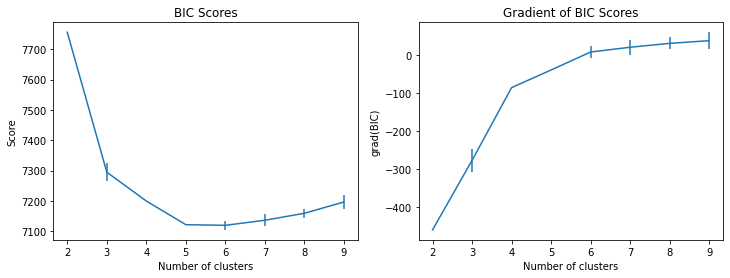

In [21]:
# find the optimal number of clusters
find_optimal_K_gmm(df = data, 
                   K = np.arange(2, 10))

Insights:
- The optimal number of clusters could be 5 clusters because the gradient of BIC doesn't improve so much after those cluster numbers which means no more information gain as we increase the number of clusters.

#### Modelling

======================================================= 5 clusters =======================================================
Total Variance Explained: 0.8960122097694587


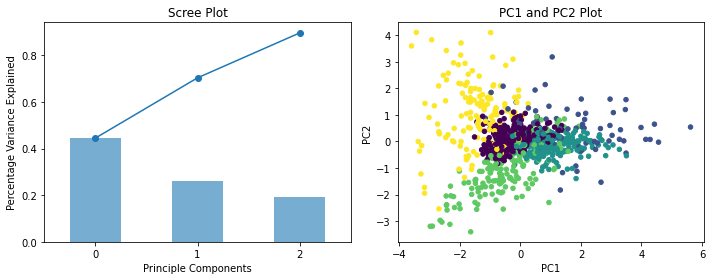

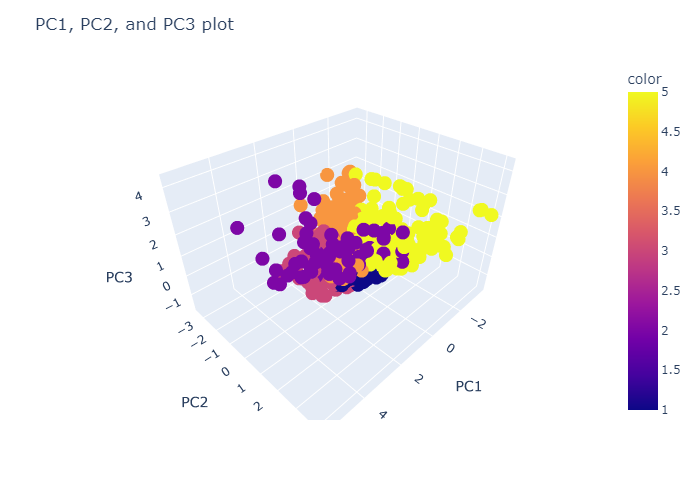

In [22]:
# get the clustering labels using GMM clustering
labels = dict()
clusters = [5]       # define number of clusters to be analyzed -> 5 clusters
for cluster in clusters:
    print('='*55, '{} clusters'.format(cluster), '='*55)
    cluster_labels, _ = gmm_clustering(k = cluster, 
                                       df_gmm = data,
                                       df_pca = scaling(data, StandardScaler()),
                                       label_name = 'Customer Labels',
                                       plot_show = True,
                                       type_cov = 'full')
    labels['{} clusters'.format(cluster)] = cluster_labels.values

#### Interpretation of clusters

We will interpret our results by using `groupby()` method for each group of clusters to see how is the mean for each cluster and using relative importance of cluster features compared to population (the customers dataframe).

======================================================= 5 clusters ==================================================


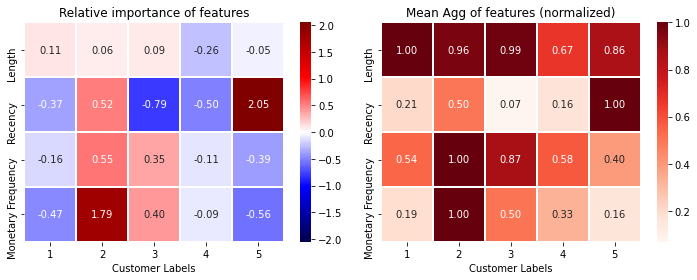

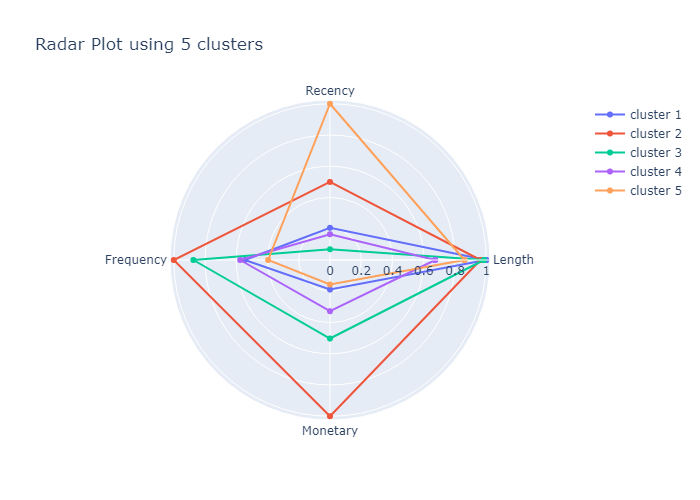

In [23]:
# Interpret the clusters
clustered_customers = customers[data.columns].copy()
for key, val in labels.items():
    print('='*55, '{}'.format(key), '='*50)
    clustered_customers['Customer Labels'] = val
    heatmap_plot(clustered_customers, label_name = 'Customer Labels')
    radar_plot(clustered_customers, label_name = 'Customer Labels', name = key)

Insights:
- We see that with 5 clusters, the characteristic (LRFM metric) of each cluster is different from each other.

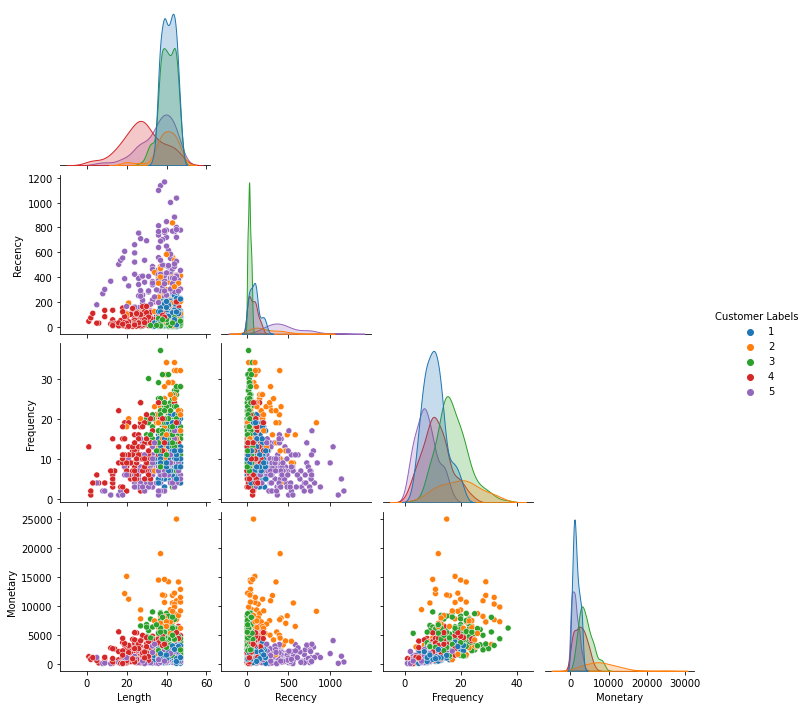

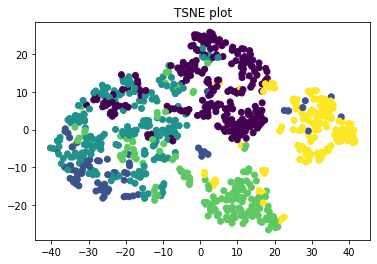

In [24]:
clustered_customers['Customer Labels'] = labels['5 clusters']
sns.pairplot(clustered_customers, hue = 'Customer Labels', palette = 'tab10', corner = True)
plt.show()

from sklearn.manifold import TSNE
tsne = TSNE(learning_rate = 'auto')
transformed = tsne.fit_transform(scaling(data, StandardScaler()))

plt.scatter(transformed[:,0], transformed[:,1],
             c = labels['5 clusters'])
plt.title('TSNE plot')
plt.show()

#### Assign the best K clusters and name each cluster

In [25]:
# assign K = 5 as the number of clusters
final_customers_gmm = customers.iloc[:, :4].copy()
final_customers_gmm['Customer Labels'] = labels['5 clusters']
final_customers_gmm.head()

,,Length,Recency,Frequency,Monetary,Customer Labels
Customer ID,Customer Name,,,,,
AA-10315,Alex Avila,45,185,11,5563.560,4
AA-10375,Allen Armold,44,20,15,1056.390,3
AA-10480,Andrew Allen,43,260,12,1790.512,5
AA-10645,Anna Andreadi,42,56,18,5086.935,3
AB-10015,Aaron Bergman,46,416,6,886.156,5


### Interpret LRFM Model (GMM)

Insights:
- `final_customers_gmm`:
    - `Cluster 1`: This can be interpreted as `"Hibernating"` customer segment. This customer has good frequency but their last purchase is quite a long ago. Spent low amount of money and old customers.
    - `Cluster 2`: This can be interpreted as `"Most Valuable at Risk"` customer segment. This customer spent the most and the most frequent buyers but they haven't purchased in the past and they are old customers.
    - `Cluster 3`: This can be interpreted as `"Loyal"` customer segment. This customer spent a lot and purchased with very good frequency and the most recently buyers. They are old customers.
    - `Cluster 4`: This can be interpreted as `"Potential"` customer segment. This customer spent fairly good amount of money although they are a new customer, purchased in the recent past with good frequency.
    - `Cluster 5`: This can be interpreted as `"Lost Cheap"`customer segment. This customer has the lowest spending of money and frequency. Their last purchase is very long ago (lost this customer) and quite old customer.

In [26]:
# final_customers_gmm

# name each segment of customers
final_customers_gmm['Customer Segment'] = final_customers_gmm['Customer Labels']\
                                                    .apply(lambda x: 'Hibernating' if x == 1 else(
                                                                     'Most Valuable at Risk' if x == 2 else(
                                                                     'Loyal' if x == 3 else(
                                                                     'Potential' if x == 4 else(
                                                                     'Lost Cheap'
                                                                     )))))
final_customers_gmm.groupby('Customer Segment').agg({'Length':'mean',
                                                        'Recency':'mean',
                                                        'Frequency':'mean',
                                                        'Monetary':['mean', 'count']}).round(2)

Length Recency Frequency Monetary      
                        mean    mean      mean     mean count
Customer Segment                                             
Hibernating            41.09   92.83     10.62  1526.71   230
Lost Cheap             35.36  450.36      7.72  1268.01   140
Loyal                  40.49   30.96     17.04  4061.25   201
Most Valuable at Risk  39.57  224.99     19.49  8082.47    67
Potential              27.67   74.25     11.21  2649.68   155

## Segmentation using Hierarchical Clustering

Hierarchical clustering is clustering algorithm based on hierarchical group of clusters which can be either in divisional or agglomerative fashion. This algorithm is more flexible and easier to interpret because we don't have to specify the number of clusters at first, instead we just have to evaluate and see the linkage on dendrogram and define the minimal distance to perform a clusters.

The linkage on dendogram is made by computing the distance matrix between clusters at each stage where we have M stage if we have M data points and at each stage we will compare the distance between a specific cluster to all the remaining clusters then assess the linkage between them based on defined linkage method.

The computational cost for this algorithm is very expensive especially when we deal with very large dataset.

### Data preprocessing

Similar to K-Means algorithm, we need to scale the features before applying Hierarchical Clustering.

These are few helper function to conduct the clustering easier.

In [27]:
# helper function for modelling using Hierarchical Clustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# modelling Hierarchical Clustering
def hierarchical_clustering(distance_matrix, k, criterion, df_pca, label_name, plot_show):
    temp_df = pd.DataFrame(fcluster(Z = distance_matrix, t = k, criterion = criterion))
    temp_df.columns = [label_name]
    
    # plot the Hierarchical Clustering result
    _ = dimen_reduction(df_pca, 
                        PC = 3, plot_PC = plot_show, labels = temp_df[label_name])
    return temp_df[label_name], _

def compute_distance_matrix(df, linkage_method):
    distance_matrix = linkage(df, method = linkage_method, metric = 'euclidean')
    fig, ax = plt.subplots(figsize = (14, 6))
    dendrogram(distance_matrix,
               labels = df.droplevel(0).index,
               leaf_rotation = 45,
               leaf_font_size = 1)
    plt.title('Dendrogram using "{}" method'.format(linkage_method))
    plt.show()
    return distance_matrix

### LRFM model

We will use the `Length`, `Recency`, `Frequency`, and `Monetary` to segment the customer behaviour.

In [28]:
# take the LRFM data
data = scaling(customers.iloc[:, :4], StandardScaler())
data.head()

,,Length,Recency,Frequency,Monetary
Customer ID,Customer Name,,,,
AA-10315,Alex Avila,0.935607,0.199889,-0.256912,1.015112
AA-10375,Allen Armold,0.816075,-0.686762,0.384256,-0.700590
AA-10480,Andrew Allen,0.696543,0.602912,-0.096620,-0.421139
AA-10645,Anna Andreadi,0.577010,-0.493311,0.865131,0.833680
AB-10015,Aaron Bergman,1.055139,1.441199,-1.058371,-0.765391


#### Compute the distance matrix and show the linkage on dendogram

There are some methods to define the linkage between clusters. We will try several methods such as  `'ward'`, `'weighted'`, `'average'`, `'median'`, `'complete'`,  and `'single'` and then implement the most reasonable linkage method based on the dendrogram.

*Note: This algorithm is slower because the computational cost is quite expensive*

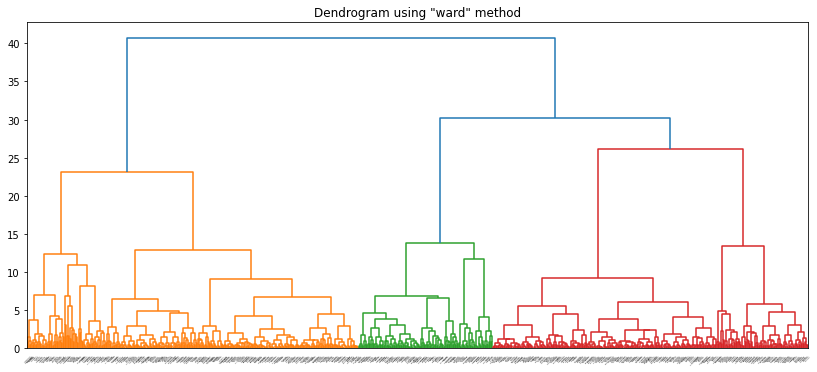

In [29]:
# compute the distance matrix and show the linkage on dendogram
methods = ['ward'] #['ward', 'weighted', 'average', 'median', 'complete', 'single']
distance_matrix = dict()
for method in methods:
    temp = compute_distance_matrix(data, linkage_method = method)
    distance_matrix[method] = temp

Insights:
- The most reasonable linkage method is `ward`. This method is preferable for dense data points as we saw in PCA plots.
- The best number of clusters are 4 clusters.

#### Modelling

======================================================= 4 clusters =======================================================
Total Variance Explained: 0.8960122097694598


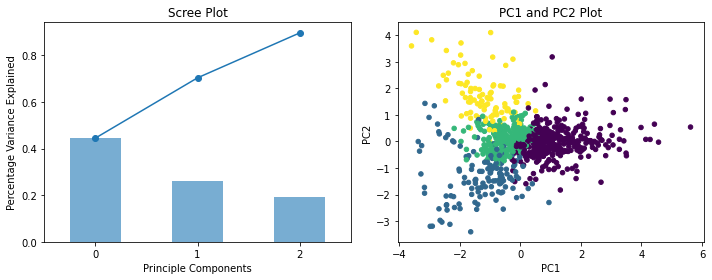

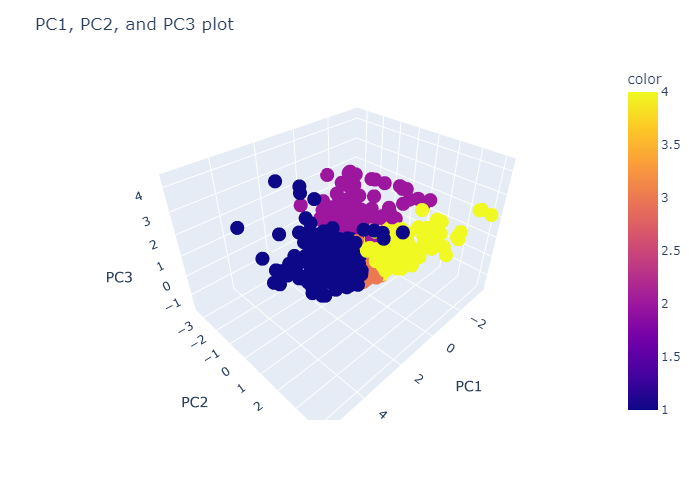

In [30]:
# get the clustering labels using Hierarchical clustering
labels = dict()
clusters = [4]       # define number of clusters to be analyzed -> 3 clusters
for cluster in clusters:
    print('='*55, '{} clusters'.format(cluster), '='*55)
    cluster_labels, _ = hierarchical_clustering(distance_matrix = distance_matrix['ward'], 
                                                k = cluster, 
                                                criterion = 'maxclust', 
                                                df_pca = scaling(data, StandardScaler()), 
                                                label_name = 'Customer Labels',
                                                plot_show = True)
    labels['{} clusters'.format(cluster)] = cluster_labels.values

#### Interpretation of clusters

We will interpret our results by using `groupby()` method for each group of clusters to see how is the mean for each cluster and using relative importance of cluster features compared to population (the customers dataframe).

======================================================= 4 clusters ==================================================


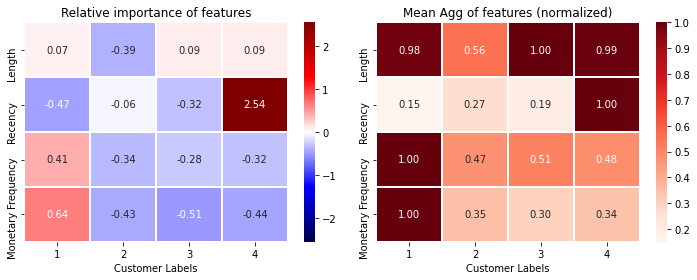

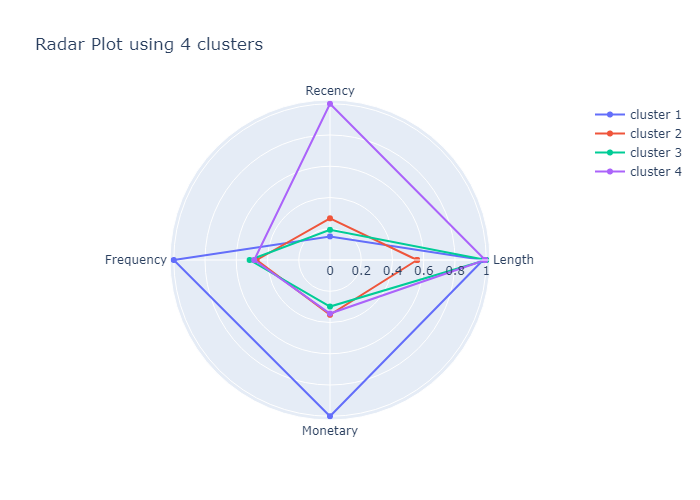

In [31]:
# Interpret the clusters
clustered_customers = customers[data.columns].copy()
for key, val in labels.items():
    print('='*55, '{}'.format(key), '='*50)
    clustered_customers['Customer Labels'] = val
    heatmap_plot(clustered_customers, label_name = 'Customer Labels')
    radar_plot(clustered_customers, label_name = 'Customer Labels', name = key)

Insights:
- We see that with 4 clusters, the characteristic (LRFM metric) of each cluster is different from each other.

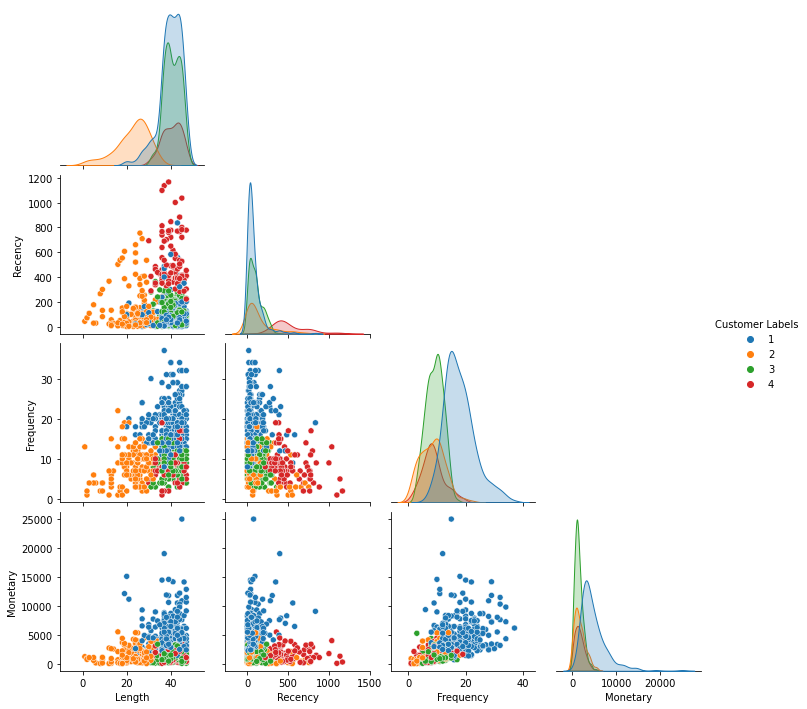

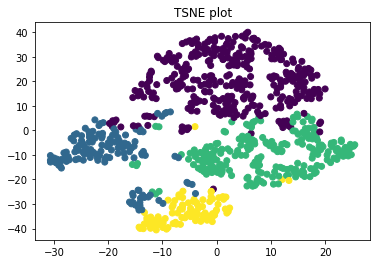

In [32]:
clustered_customers['Customer Labels'] = labels['4 clusters']
sns.pairplot(clustered_customers, hue = 'Customer Labels', palette = 'tab10', corner = True)
plt.show()

from sklearn.manifold import TSNE
tsne = TSNE(learning_rate = 'auto')
transformed = tsne.fit_transform(scaling(data, StandardScaler()))

plt.scatter(transformed[:,0], transformed[:,1],
             c = labels['4 clusters'])
plt.title('TSNE plot')
plt.show()

#### Assign the best K clusters and name each cluster

In [33]:
# assign K = 4 as the number of clusters
final_customers_hierarchical = customers.iloc[:, :4].copy()
final_customers_hierarchical['Customer Labels'] = labels['4 clusters']
final_customers_hierarchical.head()

,,Length,Recency,Frequency,Monetary,Customer Labels
Customer ID,Customer Name,,,,,
AA-10315,Alex Avila,45,185,11,5563.560,1
AA-10375,Allen Armold,44,20,15,1056.390,1
AA-10480,Andrew Allen,43,260,12,1790.512,3
AA-10645,Anna Andreadi,42,56,18,5086.935,1
AB-10015,Aaron Bergman,46,416,6,886.156,4


### Interpret LRFM Model (Hierarchical Clustering)

Insights:
- `final_customers_hierarchical`:
    - `Cluster 1`: This can be interpreted as `"Champion"` customer segment.
    - `Cluster 2`: This can be interpreted as `"Potential"` customer segment.
    - `Cluster 3`: This can be interpreted as `"Important"` customer segment.
    - `Cluster 4`: This can be interpreted as `"Lost"` customer segment.

In [34]:
# final_customers_hierarchical

# name each segment of customers
final_customers_hierarchical['Customer Segment'] = final_customers_hierarchical['Customer Labels']\
                                                    .apply(lambda x: 'Champion' if x == 1 else(
                                                                     'Potential' if x == 2 else(
                                                                     'Important' if x == 3 else(
                                                                     'Lost'))))
final_customers_hierarchical.groupby('Customer Segment').agg({'Length':'mean',
                                                        'Recency':'mean',
                                                        'Frequency':'mean',
                                                        'Monetary':['mean', 'count']}).round(2)

Length Recency Frequency Monetary      
                   mean    mean      mean     mean count
Customer Segment                                        
Champion          39.82   79.01     17.76  4744.31   337
Important         40.63  100.97      9.14  1413.56   227
Lost              40.35  523.32      8.61  1625.74    93
Potential         22.65  139.63      8.34  1663.96   136

## Compare K-Means, GMM, and Hierarchical Clustering

Calculate the Davies Bouldin Scores and Silhouette Scores for each final model.

In [35]:
data = scaling(customers, StandardScaler())

In [36]:
from sklearn import metrics
label_models = [final_customers_kmeans['Customer Labels'].values,
                final_customers_gmm['Customer Labels'].values,
                final_customers_hierarchical['Customer Labels'].values]
DBI = []
silhouette = []
n_clusters = []
for label in label_models:
    DBI.append(metrics.davies_bouldin_score(data.values, label))
    silhouette.append(metrics.silhouette_score(data.values, label))
    n_clusters.append(len(np.unique(label)))
evaluation_performance = pd.DataFrame({'davies_bouldin_score':DBI, 
                                       'silhouette_score': silhouette,
                                       'n_clusters':n_clusters})
evaluation_performance.index = ['K-Means', 'GMM', 'Hierarchical']
evaluation_performance

,davies_bouldin_score,silhouette_score,n_clusters
K-Means,1.038882,0.326900,4
GMM,1.474689,0.147293,5
Hierarchical,1.056796,0.235787,4


Insights:
- The higher the `silhouette_score` and the lower `davies_bouldin_score` then the better the model is.
- We will implement K-Means algorithm since this model has the best evaluation metric scores.